In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch
sys.path.append('../scripts/src')
from admixture_ae import AdmixtureAE

In [17]:
def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, 
                     colors=None, grid=False, reverse=False, legend=False):
    """Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)
    majority_cluster = np.argmax(data.sum(axis=1))
    print(majority_cluster)
    print(data.shape)
    data = data[:,data[majority_cluster,:].argsort()[::-1]]
    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color, width=1))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)
    plt.yticks([])
    plt.xticks([])
    if legend:
        plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

    if grid:
        plt.grid()
    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")
    plt.xlim((0, data.shape[1]))

In [3]:
def batch_generator(X, device, batch_size=0):
    if batch_size < 1:
        yield torch.tensor(X, dtype=torch.float32)
    else:
        for i in range(0, X.shape[0], batch_size):
            yield torch.tensor(X[i:i+batch_size], dtype=torch.float32, device=device)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
window_size = '100K'
tr_filename = f'/home/usuaris/imatge/albert.dominguez/data/chr22/prepared/train{window_size}.h5'
val_filename = f'/home/usuaris/imatge/albert.dominguez/data/chr22/prepared/valid{window_size}.h5'
# tr_filename = f'/mnt/gpid07/users/margarita.geleta/data/chr22/prepared/train{window_size}.h5'
# val_filename = f'/mnt/gpid07/users/margarita.geleta/data/chr22/prepared/valid{window_size}.h5'
tr_data = h5py.File(tr_filename, 'r')
val_data = h5py.File(val_filename, 'r')
X, y = tr_data['snps'], tr_data['populations']
valX, valY = val_data['snps'], val_data['populations']
_, labels_train = np.unique(y, return_inverse=True)
ancestries = ['EUR', 'EAS', 'AMR', 'SAS', 'AFR', 'OCE', 'WAS']

datafile = '../data/all_chm_combined_snps_world_2M_with_labels.npz'
npzfile = np.load(datafile, allow_pickle=True)
loaded_file = npzfile['snps']

num_features = 0
dataset = loaded_file if num_features <= 0 else loaded_file[:,:num_features]
labels_train_names = npzfile['populations']
ancestries, labels_train = np.unique(labels_train_names, return_inverse=True)
#del labels_train_names, npzfile

X, valX, y, valY = train_test_split(dataset, labels_train, test_size=.15, random_state=42)

In [6]:
batch_size = 200
loss = 'mse'
frac = 0.5
k = 7
lambda_l0 = 0.0
deep_encoder = True
init = 'minibatch_kmeans_logit'
MODELS_PATH = '../outputs'
encoder_type = 'Deep' if deep_encoder else 'Shallow'
long = True
lambda_l2 = 0.1
bnorm = 1
MODEL_NAME = f'{encoder_type}_Windowed_{window_size}_init_{init}_K_{k}_lambdal0_{lambda_l0}_{loss}_frac_{frac}_BS_{batch_size}'+(f'_l2_{lambda_l2}' if long else '') + (f'_BN_{bnorm}' if long else '') + '.pt'
print(MODEL_NAME)
# MODEL_NAME = f'Shallow_Windowed_50000_init_kmeans_logit_K_7_lambdal0_0.0_bce_frac_1.0_BS_400.pt'

Deep_Windowed_100K_init_minibatch_kmeans_logit_K_7_lambdal0_0.0_mse_frac_0.5_BS_200_l2_0.1_BN_1.pt


In [7]:
ADM = AdmixtureAE(k, X.shape[1], lambda_l0=lambda_l0, deep_encoder=deep_encoder, lambda_l2=lambda_l2, batch_norm=bnorm).to(device)
ADM.load_state_dict(torch.load(f'{MODELS_PATH}/{MODEL_NAME}'))#, map_location=torch.device('cuda')))

INFO:admixture_ae:Random decoder initialization.


<All keys matched successfully>

In [8]:
ADM.eval()
with torch.no_grad():
    #print('Computing training outputs...')
    #tr_outs = []
    #for x in batch_generator(X, device, batch_size):
    #    tr_outs.append(ADM(x)[1])
    #tr_output = torch.vstack(tr_outs)
    #del tr_outs
    print('Computing validation outputs...')
    val_outs = []
    for x in batch_generator(valX, device, batch_size):
        val_outs.append(ADM(x)[1])
    val_output = torch.vstack(val_outs)
    print('Done!')

Computing validation outputs...
Done!


In [ ]:
tr_output.detach().cpu().numpy().max(axis=1).min()

In [9]:
val_output.detach().cpu().numpy().max(axis=1).min()

0.27815193

In [ ]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0, hspace=0)
for k_idx in range(k):
    if k_idx == 0:
        ax1 = plt.subplot(1,k,k_idx+1)
    else:
        plt.subplot(1,k,k_idx+1, sharey=ax1)
    labels_plot = [str(i) for i in range(k)]
    plot_stacked_bar(tr_output.detach().cpu().T[:, np.array(y) == k_idx], labels_plot, legend=k_idx == k-1)
    plt.title(ancestries[k_idx])

1
(7, 437)
0
(7, 473)
6
(7, 338)
5
(7, 459)
2
(7, 450)
3
(7, 326)
1
(7, 350)


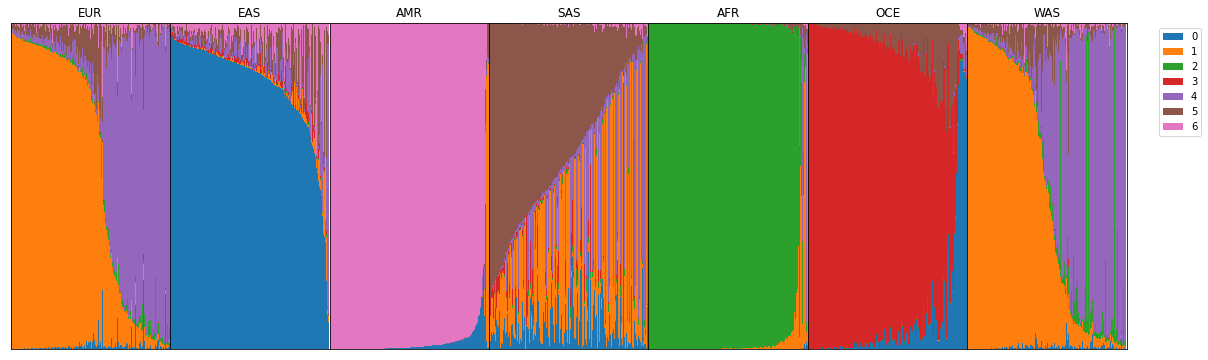

In [18]:
plt.figure(figsize=(20,6))
plt.subplots_adjust(wspace=0, hspace=0)
for k_idx in range(k):
    if k_idx == 0:
        ax1 = plt.subplot(1,k,k_idx+1)
    else:
        plt.subplot(1,k,k_idx+1, sharey=ax1)
    labels_plot = [str(i) for i in range(k)]
    plot_stacked_bar(val_output.detach().cpu().T[:, np.array(valY) == k_idx], labels_plot, legend=k_idx == k-1)
    plt.title(ancestries[k_idx])